## ABSTRACT: 
- Find the outlines for the property boundaries of the houses by viewing the nearmap image.
- Isolate the boundary for the required house and create mask to only view that house.
- Identify garden(s) in the house by isolating the color green and outline them over the image.
- Identify the percentage area of the land covered by garden(s).

The aim is to be able to identify the percentage of land area covered by garden(s) for a house. The images used for this are:
    - satelite map over the lat and lon of the house
    - cadastre boundaries over that lat and lon

# imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

# Python Code

### Image read

In [2]:
#read in color images
img_s = cv2.imread('nearmap_sat.PNG', 1)
img_b = cv2.imread('nearmap_boundaries.PNG', 1)

#read in gray image (for boundary)
img_b_g = cv2.imread('nearmap_boundaries.PNG', 0)

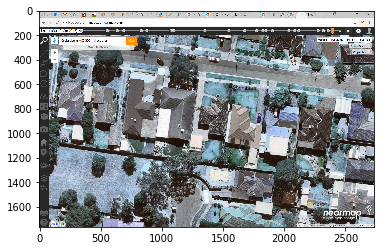

In [3]:
#view input satellite image
plt.imshow(img_s)
plt.show()

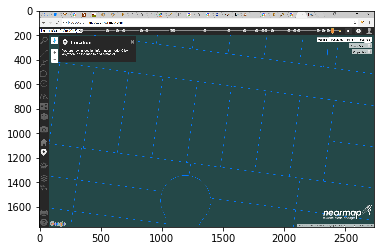

In [4]:
#view input boundary image (color)
plt.imshow(img_b)
plt.show()

### Scaling and cropping image
#### this is only done here since its a window clip rather than a static map

In [5]:
#checking image dimensions

#check the size of the images
hieght, width, channel = img_b.shape
print(hieght, width, channel)

1764 2736 3


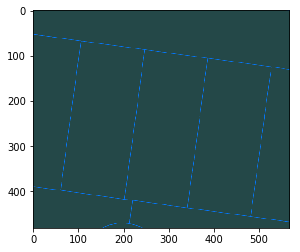

In [6]:
#crop image
img_b = img_b[400:-400, 800:-800, :]

# make the image 1/2 of it's original size
img_b = cv2.resize(img_b, None, fx=0.5, fy=0.5)

#view cropped result
plt.imshow(img_b)
plt.show()

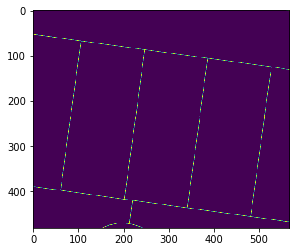

In [7]:
#crop image
img_b_g = img_b_g[400:-400, 800:-800]

# make the image 1/2 of it's original size
img_b_g = cv2.resize(img_b_g, None, fx=0.5, fy=0.5)

#view cropped result
plt.imshow(img_b_g)
plt.show()

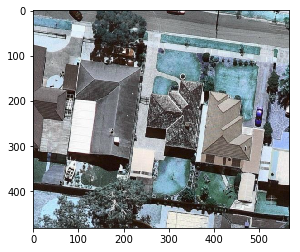

In [8]:
#crop image
img_s = img_s[400:-400, 800:-800, :]

# make the image 1/2 of it's original size
img_s = cv2.resize(img_s, None, fx=0.5, fy=0.5)

#view cropped result
plt.imshow(img_s)
plt.show()

### Finding property boundary contours

##### thresholding

In [9]:
image = img_b_g.copy()

cv2.imshow('Original', image)
cv2.waitKey(0) 

ret,thresh1 = cv2.threshold(image, 75, 255, cv2.THRESH_BINARY)
cv2.imshow('Threshold Binary', thresh1)
cv2.waitKey(0) 
cv2.destroyAllWindows()

### Finding contours for boundaries

In [10]:
#normal image 
image = thresh1.copy()

# kernel
kernel = np.ones((5,5), np.uint8)

image = cv2.dilate(image, kernel, iterations = 1)
cv2.imshow('Dilation', image)
cv2.waitKey(0)

# Canny
canny = cv2.Canny(image, 75, 76)
cv2.imshow('Canny', canny)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### fix any breaks in the edges

In [11]:
image = canny.copy()

# kernel
kernel = np.ones((2,2), np.uint8)

# Closing 
edged = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
cv2.imshow('Closing', edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### find contours

In [12]:
#normal image
image = img_b.copy()

# Finding Contours
_, contours, hierarchy = cv2.findContours(edged, 
                        cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

print("Number of Contours found = " + str(len(contours)))

# Draw contours
cv2.drawContours(image, contours, -1, (0,255,0), 1)

# view image
cv2.imshow('Contours', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Number of Contours found = 13


#### Draw individual contours and view their centers

In [13]:
#drawing found contours and their centers

n = len(contours)
min_area = 5

# for each contour in the list of contours
for i in range(n):
    
    #image to create countour on
    image = img_b.copy()
    
    #draw the contour
    cv2.drawContours(image, contours, i, (0,255,0), 1)
    
    #draw center if contour is big enough
    if cv2.contourArea(contours[i]) > min_area:
        #calculate center of contour
        M = cv2.moments(contours[i])
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        #draw contour center
        cv2.circle(image,(cx,cy), 3, (0,0,255), -1)

    #view contour
    cv2.imshow('Contours', image)
    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()
        break
    else:
        pass
    cv2.destroyAllWindows()

#### for each contour create data regarding it. (identify the center difference from image center)

In [14]:
#get the shape of the image
h, w, v = image.shape
print('hieght:', h, '\n', 'width:', w, '\n', 'value:', v)

hieght: 482 
 width: 568 
 value: 3


In [15]:
#calculate image center
ix = h/2
iy = w/2

#calculate contour centers
c_centers = []

for c in contours:
    
    #calculate contour area
    area = cv2.contourArea(c)
    
    #calculate center if area is large enough
    if cv2.contourArea(c) > 5:    
        M = cv2.moments(c) 
        cx = int(M['m10'] / M['m00']) 
        cy = int(M['m01'] / M['m00']) 
    
    else:        
        cx, cy = 0, 0
    
    #calculate distance between contour center with image center
    distance_from_center = ((cx - ix)**2 + (cy - iy)**2)**.5
    
    #store contour data
    c_centers.append((c, area , cx, cy, distance_from_center))

#### identify the contour with a center closest to the image center

In [16]:
#get the most center contour

#var to store countour with center closest to image center
closest_center_contour = None 
#var to store its center points distance from image center
contour_min_distance = np.inf 
 #var to store the area of that contour
land_area = 0

#loop over contours to find the closest one
for c_data in c_centers:
    if c_data[4] < contour_min_distance:
        contour_min_distance = c_data[4]
        closest_center_contour = c_data[0]
        land_area = c_data[1]
    else:
        pass    

#view closest centered contour on image
image = img_b.copy()
cv2.drawContours(image, [closest_center_contour], -1, (255,255,255), 2)
cv2.imshow('img', image)
cv2.waitKey()
cv2.destroyAllWindows()

#### create mask and create an image that shows only the required house

In [17]:
#only show required area of image using the contour

#image to mask over
img = img_s.copy()

#create black mask
mask = np.zeros_like(img) 
# Draw filled contour in mask
cv2.drawContours(mask, [closest_center_contour], -1, (255,255,255), -1) 

#create black canvas for output
img_s_masked = np.zeros_like(img) 
#fill the canvas with image of mask-contour index
img_s_masked[mask == 255] = img[mask == 255] 

#show masked image
cv2.imshow('out', img_s_masked)
cv2.waitKey()
cv2.destroyAllWindows()

### Now check for garden

#### convert to hsv and create a mask for green color detection

In [18]:
#view masked image in hsv

img_s_hsv_masked = cv2.cvtColor(img_s_masked, cv2.COLOR_BGR2HSV)

cv2.imshow('HSV image', img_s_hsv_masked)
cv2.imshow('Hue channel', img_s_hsv_masked[:, :, 0])
cv2.imshow('Saturation channel', img_s_hsv_masked[:, :, 1])
cv2.imshow('Value channel', img_s_hsv_masked[:, :, 2])

cv2.waitKey()
cv2.destroyAllWindows()

In [19]:
#color bounds for detecting green in masked image
#values placed by trial and error
lower_range = np.array([16, 35, 0] , dtype=np.uint8)
upper_range = np.array([64, 255, 255], dtype=np.uint8)

#create mask for green
mask_grass = cv2.inRange(img_s_hsv_masked, lower_range, upper_range)

cv2.imshow('mask', mask_grass)
cv2.imshow('img', img_s_masked)

cv2.waitKey()
cv2.destroyAllWindows()

In [20]:
#remove noise from the green mask to get a clearer image

# kernel size 
kernel = np.ones((3,3), np.uint8)

#Opening (remove external noise)
opening = cv2.morphologyEx(mask_grass, cv2.MORPH_OPEN, kernel)
cv2.imshow('Opening', opening)
cv2.waitKey(0)
cv2.destroyAllWindows()


# kernel size (this will clean the image)
kernel = np.ones((9,9), np.uint8)

# Closing (remove internal noise)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
cv2.imshow('Closing', closing)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### using the grass mask create contours over masked satelite image

In [21]:
mask_grass_denoised = closing.copy()

# create contours for the grass
_, contours, hierarchy = cv2.findContours(mask_grass_denoised, 
                    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

print("Number of Contours found = " + str(len(contours)))

final_img = img_s_masked.copy()

# Draw all contours
cv2.drawContours(final_img, contours, -1, (0,255,0), 1)
cv2.imshow('final image', final_img)
cv2.waitKey()
cv2.destroyAllWindows()

Number of Contours found = 5


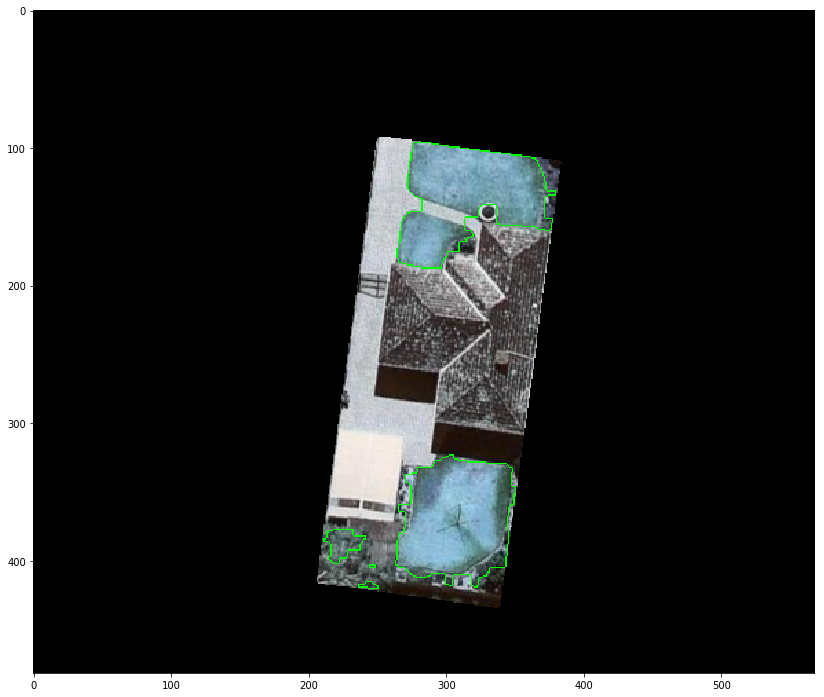

In [22]:
fig = plt.figure(figsize=(14,14))
plt.imshow(final_img)
plt.show()

### Calculate the area of the green vs land

In [23]:
#grass area total of all grass contours
grass_area = 0

#add area for each grass patch
for c in contours:
    patch_area = cv2.contourArea(c)
    grass_area += patch_area
    
#calculate percentage of grass on land
grass_land_perc = grass_area/land_area*100

#print result
print('grass area:', grass_area, '\n', 'land area:', land_area,
      '\n', 'grass v land ratio:', round(grass_land_perc,2))

grass area: 13100.0 
 land area: 43843.0 
 grass v land ratio: 29.88
